# Compare classification methods for identifying org. science perspectives in JSTOR articles
## Using balanced samples from hand-labeled set of articles

@author: Jaren Haber, PhD<br>
@coauthors: Prof. Heather Haveman, UC Berkeley; Yoon Sung Hong, Wayfair<br>
@contact: Jaren.Haber@georgetown.edu<br>
@project: Computational Literature Review of Organizational Scholarship<br>
@date: December 2020

'''
Trains classifiers to predict whether an article is about a given perspective in org. science. To train the classifiers, uses preliminary labeled articles, broken down as follows: 
Cultural: 105 yes, 209 no
Relational: 92 yes, 230 no
Demographic: 77 yes, 249 no
Compares f1_weighted scores of four model structures using 10-Fold Cross Validation: Logistic regression, SVM, Naive Bayes, and Decision Tree. Oversamples training data to .7 (7:10 minority:majority class).
'''

## Initialize

In [1]:
!pip install nltk

     |████████████████████████████████| 1.4MB 6.6MB/s eta 0:00:01
     |████████████████████████████████| 307kB 22.3MB/s eta 0:00:01
     |████████████████████████████████| 675kB 26.5MB/s eta 0:00:01
     |████████████████████████████████| 81kB 28.7MB/s eta 0:00:01
  Stored in directory: /home/jovyan/.cache/pip/wheels/ae/8c/3f/b1fe0ba04555b08b57ab52ab7f86023639a526d8bc8d384306
Successfully built nltk


In [1]:
######################################################
# Import libraries
######################################################

import pandas as pd
import numpy as np
import re
from collections import Counter
from datetime import date
from tqdm import tqdm
import os

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')

stemmer = WordNetLemmatizer()

from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

import joblib
import csv

from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, KFold

# !pip install imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import sys; sys.path.insert(0, "../preprocess/") # For loading functions from files in other directory
from quickpickle import quickpickle_dump, quickpickle_load # custom scripts for quick saving & loading to pickle format

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
######################################################
# Define filepaths
######################################################

cwd = os.getcwd()
root = str.replace(cwd, 'classification/modeling', '')
thisday = date.today().strftime("%m%d%y")

# Directory for prepared data and trained models: save files here
data_fp = root + 'classification/data/'
model_fp = root + 'classification/models/'

# Current article lists
article_list_fp = data_fp + 'filtered_length_index.csv' # Filtered index of research articles
article_paths_fp = data_fp + 'filtered_length_article_paths.csv' # List of article file paths

# Preprocessed training data
cult_labeled_fp = data_fp + 'training_cultural_preprocessed_022621.pkl'
relt_labeled_fp = data_fp + 'training_relational_preprocessed_022621.pkl'
demog_labeled_fp = data_fp + 'training_demographic_preprocessed_022621.pkl'
orgs_labeled_fp = data_fp + 'training_orgs_preprocessed_022621.pkl'

# Model filepaths
cult_model_fp = model_fp + f'classifier_cult_MLP_{str(thisday)}.joblib'
relt_model_fp = model_fp + f'classifier_relt_MLP_{str(thisday)}.joblib'
demog_model_fp = model_fp + f'classifier_demog_MLP_{str(thisday)}.joblib'
orgs_model_fp = model_fp + f'classifier_orgs_MLP_{str(thisday)}.joblib'

# Vectorizers trained on hand-coded data (use to limit vocab of input texts)
cult_vec_fp = model_fp + 'vectorizer_cult_022621.joblib'
relt_vec_fp = model_fp + 'vectorizer_relt_022621.joblib'
demog_vec_fp = model_fp + 'vectorizer_demog_022621.joblib'
orgs_vec_fp = model_fp + 'vectorizer_orgs_022621.joblib'

## Load & inspect data

In [3]:
cult_df = quickpickle_load(cult_labeled_fp)
relt_df = quickpickle_load(relt_labeled_fp)
demog_df = quickpickle_load(demog_labeled_fp)
orgs_df = quickpickle_load(orgs_labeled_fp)

cult_df.head(10)

,text,cultural_score,primary_subject,edited_filename,article_name
0,"[[research, note, church_membership, netherlan...",0.0,Sociology,10.1086_210179,Where Do Interorganizational Networks Come From?
1,"[[polish, io_oo, sociological_review, issn, co...",1.0,Sociology,10.1086_210317,Civil Rights Law at Work: Sex Discrimination a...
2,"[[article, jjdlbsj, grapliy, compassionate, eg...",0.0,Sociology,10.1086_231084,Between Markets and Politics: Organizational R...
3,"[[reply, allison, more, comparing, regression_...",1.0,Sociology,10.1086_231174,World Society and the Nation‐State
4,"[[determinants, spousal, interaction, marital,...",1.0,Sociology,10.1086_382347,Kinship Networks and Entrepreneurs in China’s ...
5,"[[wsê, ih, ompany, profile, john, porter, musé...",1.0,Sociology,10.1086_517899,What Is Organizational Imprinting? Cultural En...
6,"[[andrew_christensen, university_california, l...",1.0,Sociology,10.1086_588742,"Homeward Bound? Interest, Identity, and Invest..."
7,"[[lawyers, consumer_protection, laws, stewart_...",0.0,Sociology,10.1086_657524,Corporate Unity in American Trade Policy: A Ne...
8,"[[establishing, sense, personal, control, tran...",1.0,Sociology,10.1086_659639,The Credit Crisis as a Problem in the Sociolog...
9,"[[guess, who, coming, town, white_supremacy, e...",0.0,Sociology,10.1525_irqr.2011.4.3.199,"Science, Health, and Nationhood"


In [4]:
# Check score distribution across classes
print(cult_df.groupby('cultural_score').size())
print()
print(relt_df.groupby('relational_score').size())
print()
print(demog_df.groupby('demographic_score').size())
print()
print(orgs_df.groupby('orgs_score').size())

cultural_score
0.0    475
0.5     24
1.0    234
dtype: int64

relational_score
0.0    420
0.5     29
1.0    287
dtype: int64

demographic_score
0.0    477
0.5      7
1.0    256
dtype: int64

orgs_score
0.0    303
0.5     10
1.0    511
dtype: int64


In [5]:
# Drop unsure cases: where X_score = 0.5
drop_unsure = True

if drop_unsure:
    cult_df_yes = cult_df[cult_df['cultural_score'] == 1.0]
    cult_df_no = cult_df[cult_df['cultural_score'] == 0.0]
    cult_df = pd.concat([cult_df_yes, cult_df_no])
    
    relt_df_yes = relt_df[relt_df['relational_score'] == 1.0]
    relt_df_no = relt_df[relt_df['relational_score'] == 0.0]
    relt_df = pd.concat([relt_df_yes, relt_df_no])
    
    demog_df_yes = demog_df[demog_df['demographic_score'] == 1.0]
    demog_df_no = demog_df[demog_df['demographic_score'] == 0.0]
    demog_df = pd.concat([demog_df_yes, demog_df_no])
    
    orgs_df_yes = orgs_df[orgs_df['orgs_score'] == 1.0]
    orgs_df_no = orgs_df[orgs_df['orgs_score'] == 0.0]
    orgs_df = pd.concat([orgs_df_yes, orgs_df_no])

### Check vocab size and frequent words

In [6]:
def collect_article_tokens(article, return_string=False):
    '''
    Collects words from already-tokenized sentences representing each article.
    
    Args:
        article: list of lists of words (each list is a sentence)
        return_string: whether to return single, long string representing article
    Returns:
        tokens: string if return_string, else list of tokens
    '''
    
    tokens = [] # initialize
    
    if return_string:
        for sent in article:
            sent = ' '.join(sent) # make sentence into a string
            tokens.append(sent) # add sentence to list of sentences
        tokens = ' '.join(tokens) # join sentences into string
        return tokens # return string
    
    else:
        for sent in article:
            tokens += [word for word in sent] # add each word to list of tokens
        return tokens # return list of tokens

# For capturing word frequencies, add all words from each article to single, shared list (can't use this to create models)
cult_tokens = []; cult_df['text'].apply(lambda article: cult_tokens.extend([word for word in collect_article_tokens(article)]))
relt_tokens = []; relt_df['text'].apply(lambda article: relt_tokens.extend([word for word in collect_article_tokens(article)]))
demog_tokens = []; demog_df['text'].apply(lambda article: demog_tokens.extend([word for word in collect_article_tokens(article)]))
orgs_tokens = []; orgs_df['text'].apply(lambda article: orgs_tokens.extend([word for word in collect_article_tokens(article)]))
print()

In [8]:
# Look at size of vocabulary and most frequent words
tokens = ((cult_tokens + relt_tokens) + demog_tokens) + orgs_tokens
print('Vocab size:', len(set(tokens)))
print()

# Check out most frequent words in labeled texts
freq = Counter(tokens)
print('20 most frequent words in labeled articles:')
freq.most_common(20)

Vocab size: 169701

20 most frequent words in labeled articles:


[('from', 89011),
 ('social', 77638),
 ('have', 73580),
 ('we', 70788),
 ('more', 68737),
 ('which', 66698),
 ('were', 65677),
 ('one', 55317),
 ('other', 44993),
 ('than', 43319),
 ('may', 43175),
 ('also', 41037),
 ('all', 40362),
 ('can', 39250),
 ('research', 38752),
 ('between', 38287),
 ('who', 37469),
 ('time', 35868),
 ('has', 33474),
 ('when', 33441)]

### Check frequent sentences (to improve cleaning)

In [11]:
# Add sentences from each article to empty list:
cult_sents = []; cult_df['text'].apply(
    lambda article: cult_sents.extend(
        [' '.join([word for word in sent]) for sent in article]))
relt_sents = []; relt_df['text'].apply(
    lambda article: relt_sents.extend(
        [' '.join([word for word in sent]) for sent in article]))
demog_sents = []; demog_df['text'].apply(
    lambda article: demog_sents.extend(
        [' '.join([word for word in sent]) for sent in article]))
orgs_sents = []; orgs_df['text'].apply(
    lambda article: orgs_sents.extend(
        [' '.join([word for word in sent]) for sent in article]))

sents = ((cult_sents + relt_sents) + demog_sents) + orgs_sents
print('Number of sentences:', len(sents))
print()

# Check out most frequent sentences in labeled texts
freq = Counter(sents)
print('20 most frequent sentences in labeled articles:')
freq.most_common(100)

Number of sentences: 113692

20 most frequent sentences in labeled articles:


[('entry', 12932),
 ('bottom_entry', 8227),
 ('align', 8045),
 ('row', 4734),
 ('align_center', 2573),
 ('bottom', 2279),
 ('align_left', 2004),
 ('colspec_colnum', 774),
 ('top entry', 542),
 ('caption', 430),
 ('label_label', 424),
 ('tex_math notation_latex', 404),
 ('documentclass_aastex', 404),
 ('usepackage_amsbsy', 404),
 ('usepackage_amsfonts', 404),
 ('usepackage_amssymb', 404),
 ('usepackage_bm', 404),
 ('usepackage_mathrsfs', 404),
 ('usepackage_pifont', 404),
 ('usepackage_stmaryrd', 404),
 ('usepackage_textcomp', 404),
 ('usepackage_portland xspace', 404),
 ('usepackage_amsmath amsxtra', 404),
 ('usepackage_ot ot_fontenc', 404),
 ('newcommand_cyr', 404),
 ('renewcommand_rmdefault wncyr', 404),
 ('renewcommand_sfdefault wncyss', 404),
 ('renewcommand_encodingdefault ot', 404),
 ('normalfont', 404),
 ('selectfont', 404),
 ('declaretextfontcommand_extcyr cyr', 404),
 ('pagestyle_empty', 404),
 ('declaremathsizes', 404),
 ('begin_document', 404),
 ('landscape', 404),
 ('end_do

### Load and apply text vectorizers

In [12]:
# Collect articles: Add each article as single str to list of str:
cult_docs = [] # empty list
cult_df['text'].apply(
    lambda article: cult_docs.append(
        collect_article_tokens(
            article, 
            return_string=True)))

relt_docs = [] # empty list
relt_df['text'].apply(
    lambda article: relt_docs.append(
       collect_article_tokens(
            article, 
            return_string=True)))

demog_docs = [] # empty list
demog_df['text'].apply(
    lambda article: demog_docs.append(
        collect_article_tokens(
            article, 
            return_string=True)))

orgs_docs = [] # empty list
orgs_df['text'].apply(
    lambda article: orgs_docs.append(
        collect_article_tokens(
            article, 
            return_string=True)))

print() # skip weird output

In [16]:
# Define stopwords used by JSTOR
jstor_stopwords = set(["a", "an", "and", "are", "as", "at", "be", "but", "by", "for", "if", "in", "into", "is", "it", "no", "not", "of", "on", "or", "such", "that", "the", "their", "then", "there", "these", "they", "this", "to", "was", "will", "with"])

# Uses TFIDF weighted DTM because results in better classifier accuracy than unweighted
cult_vectorizer = joblib.load(cult_vec_fp, "r+")
X_cult = cult_vectorizer.transform(cult_docs)
print('Number of features in cultural vectorizer:', len(cult_vectorizer.get_feature_names()))
print('Every 1000th word:\n{}'.format(cult_vectorizer.get_feature_names()[::1000])) # get every 1000th word
print()

relt_vectorizer = joblib.load(relt_vec_fp, "r+")
X_relt = relt_vectorizer.transform(relt_docs)
print('Number of features in relational vectorizer:', len(relt_vectorizer.get_feature_names()))
print('Every 1000th word:\n{}'.format(relt_vectorizer.get_feature_names()[::1000])) # get every 1000th word
print()

demog_vectorizer = joblib.load(demog_vec_fp, "r+")
X_demog = demog_vectorizer.transform(demog_docs)
print('Number of features in demographic vectorizer:', len(demog_vectorizer.get_feature_names()))
print('Every 1000th word:\n{}'.format(demog_vectorizer.get_feature_names()[::1000])) # get every 1000th word
print()

orgs_vectorizer = joblib.load(orgs_vec_fp, "r+")
X_orgs = orgs_vectorizer.transform(orgs_docs)
print('Number of features in organizational soc vectorizer: {}'.format(len(orgs_vectorizer.get_feature_names())))
print('Every 1000th word:\n{}'.format(orgs_vectorizer.get_feature_names()[::1000])) # get every 1000th word

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.24.1 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.24.1 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Number of features in cultural vectorizer: 100000
Every 1000th word:
['_author', 'achivement', 'aerotic', 'alam', 'amazon_basin', 'anjlated', 'appropriated', 'attacks', 'barbara_entwisle', 'berlin_berlin', 'boles', 'brotherhood', 'cantonments', 'cfi_comparative', 'ciu', 'collects', 'conceptually', 'convoluted', 'criticised', 'daunting_task', 'demonized', 'diesel_engines', 'distributed', 'dst', 'efforts', 'enhance_interpretability', 'euroqol', 'fabrigar', 'fictional', 'foreignness', 'furstenberg', 'giddens', 'greenfeld', 'hard_currency', 'het_erogeneity', 'hospital_bed', 'illuminate', 'infants', 'internally_consistent', 'jaffee_david', 'kagono_nonaka', 'kockott', 'latham_wexley', 'liebling', 'loseke_eds', 'manager', 'mazur', 'mexican_immigrants', 'modifier', 'murdie', 'neter_john', 'norfolk', 'oil_spills', 'ot_ot', 'paris_harmattan', 'perks', 'plea_negotiation', 'praeger_publishers', 'processors', 'psych_bull', 'qtj', 'ramadan', 'reappeared', 'referrals', 'relmo', 'residen_tial', 'rffir

## Setup for modeling

In [17]:
######################################################
# Balance x_train, y_train
######################################################

def resample_data(X_train, Y_train, undersample = False, sampling_ratio = 1.0):
    """
    Args:
        X_train: X training data
        Y_train: Y training data
        undersample: boolean for over or undersampling
        sampling_ratio: ratio of minority to majority class
        
        archived/not used:
        sampling_strategy: strategy for resampled distribution
            if oversample: 'majority' makes minority = to majority
            if undersample: 'minority' makes majority = to minority
            
    Returns:
        X_balanced: predictors at balanced ratio
        Y_balanced: outcomes at balanced ratio
    """
    
    if undersample == True:
        undersample = RandomUnderSampler(sampling_strategy=sampling_ratio)
        X_balanced, Y_balanced = undersample.fit_resample(X_train, Y_train)
    else:
        oversample = RandomOverSampler(sampling_strategy=sampling_ratio)
        X_balanced, Y_balanced = oversample.fit_resample(X_train, Y_train)
    
    print(f'Y_train: {Counter(Y_train)}\nY_resample: {Counter(Y_balanced)}')
    
    return X_balanced, Y_balanced

In [18]:
def compute_predictions(text, vectorizer_model, class_model):
    '''
    Predicts the label for an input text using a given model trained to classify the texts. 
    Uses vectorizer_model to restrict the vocab of the input text so it's consistent with vocab in class_model (avoids errors).
    
    Args:
        text: preprocessed text in format of list of sentences, each a str or list of tokens
        vectorizer_model: fitted text vectorizer
        class_model: trained classification model
    Returns:
        label: label for text predicted by model, false for tie
        prob: probability for label
    '''
    
    X = vectorizer_model.transform(text) # create TF-IDF-weighted DTM from text
    try:
        probabilities = class_model.predict_proba(X)
    except: 
        return
    
    label = 'no'
    prob_no = probabilities[0][0]
    prob_yes = probabilities[0][1]
    
    # predicted label is one with greater probability
    if probabilities[0][0] < probabilities[0][1]:
        label = 'yes'
        
    return label, prob_yes, prob_no

In [19]:
######################################################
# k-fold cross validation for model evaluation
######################################################

# Define test options for k-fold CV
num_folds = 10 
seed = 3
scoring='f1_weighted' # set scoring metric (not used here)

def show_kfold_output(models,  
                      X, 
                      Y, 
                      df, 
                      text_col, 
                      vectorizer, 
                      num_folds = num_folds, 
                      random_state = seed, 
                      shuffle = True):
    '''
    Estimates the accuracy of different model algorithms, adds results to a results array and returns.
    Prints the accuracy results: averages and std.
    Uses cross_val_predict, which unlike cross_val_score cannot define scoring option/evaluation metric.
    
    Args:
        models: list of (name, model) tuples
        X: predictors
        Y: outcomes
        num_folds: Split data randomly into num_folds parts: (num_folds-1) for training, 1 for scoring
        random_state: seed
        shuffle: 
    
    Returns:
        results: list of model results
        names: list of model names (matches results)
        
    Source: 
        https://stackoverflow.com/questions/40057049/using-confusion-matrix-as-scoring-metric-in-cross-validation-in-scikit-learn
    '''
    
    results = []
    names = []
    
    for name, model in models:
        # Print name of model
        print(f'{name}:')
        print()
        
        # Setup model options
        kfold = KFold(
            n_splits=num_folds, 
            random_state=seed, 
            shuffle=True)
        
        # Get kfold results
        cv_results = cross_val_predict(
            model.fit(X, Y), 
            X, 
            Y, 
            cv=kfold, 
            #scoring=scoring, 
            n_jobs=-1) # use all cores = faster
        
        # Add results and name of each algorithm to the model array
        results.append(cv_results)
        names.append(name)
        
        # Validation step: Predict class probabilities in labeled data, compare to actual labels
        try:
            tqdm.pandas(desc="Computing predictions")
            df[['prediction', 'prediction_prob_yes', 'prediction_prob_no']] = df[text_col].progress_apply(
            lambda text: pd.Series(
                compute_predictions(
                    [' '.join(sent) for sent in sent_tokenize(text)], 
                    vectorizer, model)))
            print("Distribution of predicted labels:\n", df['prediction'].value_counts()) # show predicted distribution, compare to labeled distribution
            print()
        except: 
            pass
        
        # Print results
        print(f'Mean (std):\t {round(cv_results.mean(),4)} ({round(cv_results.std(),4)})')
        print(f'Accuracy:\t', {round(accuracy_score(Y, cv_results)), 4})
        print()
        print('Confusion matrix:\n', confusion_matrix(Y, cv_results))
        print()
        print('Report:\n', classification_report(Y, cv_results))
        print()
        
    # Return arrays
    return results, names

## Evaluate algorithms: Cultural perspective

In [22]:
######################################################
# Prepare training and validation data
######################################################

# Separate training and final validation data set. First remove class
# label from data (X). Setup target class (Y)
# Then make the validation set 10% of the entire
# set of labeled data (X_validate, Y_validate)

cult_df = cult_df[['text', 'cultural_score']]
print("Number of cases:", str(X_cult.shape[0]))

valueArray = cult_df.values
Y = valueArray[:,1]
Y = Y.astype('float')
print("Number of codes (should match):", str(len(Y)))

Number of cases: 709
Number of codes (should match): 709


In [23]:
######################################################
# Oversample to desirable ratio
######################################################

# Use these settings here and below
seed = 43 # for randomizing
sampling_ratio = 1.0 # ratio of minority to majority cases
undersample = False # whether to undersample or oversample

X_balanced, Y_balanced = resample_data(
    X_cult, 
    Y, 
    undersample=undersample, 
    sampling_ratio=sampling_ratio)

Y_train: Counter({0.0: 475, 1.0: 234})
Y_resample: Counter({1.0: 475, 0.0: 475})


In [25]:
######################################################
# Use different algorithms to build models
######################################################

mlp = MLPClassifier(random_state=seed, max_iter=200, activation='relu', 
                    alpha=0.0001, hidden_layer_sizes=(50, 50), 
                    learning_rate='adaptive', solver='adam')

#ensemble = 

models = []
models.append(('K-Nearest Neighbors (KNN)', KNeighborsClassifier()))
models.append(('Random Forest (RF)', RandomForestClassifier(random_state=seed)))
models.append(('Decision Tree (DT)', DecisionTreeClassifier(random_state=seed)))
models.append(('Multinomial Naive Bayes (MNB)', MultinomialNB()))
models.append(('Logistic Regression (LR)', LogisticRegression(random_state=seed)))
models.append(('Support Vector Machine (SVM)', SVC(gamma='auto')))
models.append(('Multi-Layer Perceptron (MLP)', mlp))
#models.append(('Ensemble model (MLP + Logit)', ensemble))

# Baseline: distribution of labeled data
print(f'Distribution of labeled cultural articles: {Counter(Y).most_common()}')
print()

# Evaluate algorithms using 10-fold cross validation
results, names = show_kfold_output(models=models, 
                                   X=X_balanced,
                                   Y=Y_balanced, 
                                   df=cult_df, 
                                   text_col='text', 
                                   vectorizer=cult_vectorizer)

Distribution of labeled cultural articles: [(0.0, 475), (1.0, 234)]

K-Nearest Neighbors (KNN):



Computing predictions:   0%|          | 1/709 [00:00<00:10, 65.09it/s]


Mean (std):	 0.6305 (0.4827)
Accuracy:	 {1, 4}

Confusion matrix:
 [[185 290]
 [166 309]]

Report:
               precision    recall  f1-score   support

         0.0       0.53      0.39      0.45       475
         1.0       0.52      0.65      0.58       475

    accuracy                           0.52       950
   macro avg       0.52      0.52      0.51       950
weighted avg       0.52      0.52      0.51       950


Random Forest (RF):



Computing predictions:   0%|          | 1/709 [00:00<00:00, 898.14it/s]


Mean (std):	 0.4347 (0.4957)
Accuracy:	 {1, 4}

Confusion matrix:
 [[453  22]
 [ 84 391]]

Report:
               precision    recall  f1-score   support

         0.0       0.84      0.95      0.90       475
         1.0       0.95      0.82      0.88       475

    accuracy                           0.89       950
   macro avg       0.90      0.89      0.89       950
weighted avg       0.90      0.89      0.89       950


Decision Tree (DT):



Computing predictions:   0%|          | 1/709 [00:00<00:00, 900.07it/s]


Mean (std):	 0.6337 (0.4818)
Accuracy:	 {1, 4}

Confusion matrix:
 [[291 184]
 [ 57 418]]

Report:
               precision    recall  f1-score   support

         0.0       0.84      0.61      0.71       475
         1.0       0.69      0.88      0.78       475

    accuracy                           0.75       950
   macro avg       0.77      0.75      0.74       950
weighted avg       0.77      0.75      0.74       950


Multinomial Naive Bayes (MNB):



Computing predictions:   0%|          | 1/709 [00:00<00:00, 941.06it/s]


Mean (std):	 0.6653 (0.4719)
Accuracy:	 {1, 4}

Confusion matrix:
 [[249 226]
 [ 69 406]]

Report:
               precision    recall  f1-score   support

         0.0       0.78      0.52      0.63       475
         1.0       0.64      0.85      0.73       475

    accuracy                           0.69       950
   macro avg       0.71      0.69      0.68       950
weighted avg       0.71      0.69      0.68       950


Logistic Regression (LR):



Computing predictions:   0%|          | 1/709 [00:00<00:01, 538.08it/s]


Mean (std):	 0.5179 (0.4997)
Accuracy:	 {1, 4}

Confusion matrix:
 [[341 134]
 [117 358]]

Report:
               precision    recall  f1-score   support

         0.0       0.74      0.72      0.73       475
         1.0       0.73      0.75      0.74       475

    accuracy                           0.74       950
   macro avg       0.74      0.74      0.74       950
weighted avg       0.74      0.74      0.74       950


Support Vector Machine (SVM):



Computing predictions:   0%|          | 1/709 [00:00<00:00, 722.04it/s]


Mean (std):	 0.5 (0.5)
Accuracy:	 {0, 4}

Confusion matrix:
 [[222 253]
 [253 222]]

Report:
               precision    recall  f1-score   support

         0.0       0.47      0.47      0.47       475
         1.0       0.47      0.47      0.47       475

    accuracy                           0.47       950
   macro avg       0.47      0.47      0.47       950
weighted avg       0.47      0.47      0.47       950


Multi-Layer Perceptron (MLP):



Computing predictions:   0%|          | 1/709 [00:00<00:04, 171.95it/s]

Mean (std):	 0.4884 (0.4999)
Accuracy:	 {1, 4}

Confusion matrix:
 [[409  66]
 [ 77 398]]

Report:
               precision    recall  f1-score   support

         0.0       0.84      0.86      0.85       475
         1.0       0.86      0.84      0.85       475

    accuracy                           0.85       950
   macro avg       0.85      0.85      0.85       950
weighted avg       0.85      0.85      0.85       950




In [ ]:
######################################################
# Save best model
######################################################

best_model_suffix = "MLP" # selected model
cult_model_fp = model_fp + f'classifier_cult_{str(best_model_suffix)}_{str(thisday)}.joblib'

# cult_model = MLPClassifier(max_iter=100, activation='relu').fit(X_balanced, Y_balanced) 
             # DecisionTreeClassifier(random_state=seed).fit(X_balanced, Y_balanced) 
             # RandomForestClassifier(random_state=seed).fit(X_balanced, Y_balanced)
        
joblib.dump(cult_model, cult_model_fp)

### Validation step: Use selected model to predict class probabilities in training data

In [ ]:
def compute_predictions(text, vectorizer_model, class_model):
    '''
    Predicts the label for an input article using a given model trained to classify organizational perspectives in articles. 
    Uses vectorizer_model to restrict the vocab of the input article so it's consistent with vocab in class_model (avoids errors).
    
    Args:
        text: preprocessed article text in format of list of sentences, each a str or list of tokens
        vectorizer_model: fitted text vectorizer
        class_model: trained classification model
    Returns:
        label: label for text predicted by model, false for tie
        prob: probability for label
    '''
    
    X = vectorizer_model.transform(text) # create TF-IDF-weighted DTM from text
    probabilities = class_model.predict_proba(X)
    
    label = 'no'
    prob_no = probabilities[0][0]
    prob_yes = probabilities[0][1]
    
    # predicted label is one with greater probability
    if probabilities[0][0] < probabilities[0][1]:
        label = 'yes'
        
    return label, prob_yes, prob_no

In [ ]:
# Make predictions
#cult_model = MLPClassifier(max_iter=100, activation='relu').fit(X_cult, Y) # DecisionTreeClassifier(random_state=seed).fit(X_relt, Y)
tqdm.pandas(desc = "Predicting: cultural persp.")
cult_df[['prediction_cult','prediction_cult_prob_yes','prediction_cult_prob_no']] = cult_df['text'].progress_apply(lambda sentlist: pd.Series(compute_predictions([' '.join(sent) for sent in sentlist], cult_vectorizer, cult_model)))

In [ ]:
# Check out predictions: labels should be balanced
pred_col = 'prediction_cult'
cult_df[pred_col].value_counts()

In [3]:
# Compare to distribution of labeled data
print(f'Distribution of labeled cultural data: {Counter(Y_balanced).most_common()}')

NameError: name 'Y' is not defined

In [4]:
# Check out predicted probabilities: Distribution should be balanced
prob_col = 'prediction_cult_prob_yes'
cult_df[prob_col].hist(bins=50)

NameError: name 'cult_df' is not defined

## Evaluate algorithms: Relational perspective

In [26]:
######################################################
# Prepare training and validation data
######################################################

# Separate training and final validation data set. First remove class
# label from data (X). Setup target class (Y)
# Then make the validation set 10% of the entire
# set of labeled data (X_validate, Y_validate)

relt_df = relt_df[['text', 'relational_score']]
print("Number of cases:", str(X_relt.shape[0]))

valueArray = relt_df.values
Y = valueArray[:,1]
Y = Y.astype('float')
print("Number of codes (should match):", str(len(Y)))

Number of cases: 707
Number of codes (should match): 707
Y_train Distribution: [(0.0, 339), (1.0, 226)]


In [27]:
######################################################
# Oversample to desirable ratio
######################################################

X_balanced, Y_balanced = resample_data(
    X_relt, Y, 
    undersample=undersample, 
    sampling_ratio=sampling_ratio)

Y_train: Counter({0.0: 420, 1.0: 287})
Y_resample: Counter({1.0: 420, 0.0: 420})


In [28]:
######################################################
# Use different algorithms to build models
######################################################

models = []
models.append(('K-Nearest Neighbors (KNN)', KNeighborsClassifier()))
models.append(('Random Forest (RF)', RandomForestClassifier(random_state=seed)))
models.append(('Decision Tree (DT)', DecisionTreeClassifier(random_state=seed)))
models.append(('Multinomial Naive Bayes (MNB)', MultinomialNB()))
models.append(('Logistic Regression (LR)', LogisticRegression(random_state=seed)))
models.append(('Support Vector Machine (SVM)', SVC(gamma='auto')))
models.append(('Multi-Layer Perceptron (MLP)', mlp))
#models.append(('Ensemble model (MLP + Logit)', ensemble))

# Baseline: distribution of labeled data
print(f'Distribution of labeled relational articles: {Counter(Y).most_common()}')
print()

# Evaluate algorithms using 10-fold cross validation
results, names = show_kfold_output(models=models, 
                                   X=X_balanced,
                                   Y=Y_balanced, 
                                   df=relt_df, 
                                   text_col='text', 
                                   vectorizer=relt_vectorizer)

Distribution of labeled relational articles: [(0.0, 420), (1.0, 287)]

K-Nearest Neighbors (KNN):



Computing predictions:   0%|          | 1/709 [00:00<00:00, 996.27it/s]


Mean (std):	 0.4988 (0.5)
Accuracy:	 {1, 4}

Confusion matrix:
 [[241 179]
 [180 240]]

Report:
               precision    recall  f1-score   support

         0.0       0.57      0.57      0.57       420
         1.0       0.57      0.57      0.57       420

    accuracy                           0.57       840
   macro avg       0.57      0.57      0.57       840
weighted avg       0.57      0.57      0.57       840


Random Forest (RF):



Computing predictions:   0%|          | 1/709 [00:00<00:00, 810.96it/s]


Mean (std):	 0.3583 (0.4795)
Accuracy:	 {1, 4}

Confusion matrix:
 [[371  49]
 [168 252]]

Report:
               precision    recall  f1-score   support

         0.0       0.69      0.88      0.77       420
         1.0       0.84      0.60      0.70       420

    accuracy                           0.74       840
   macro avg       0.76      0.74      0.74       840
weighted avg       0.76      0.74      0.74       840


Decision Tree (DT):



Computing predictions:   0%|          | 1/709 [00:00<00:00, 922.64it/s]


Mean (std):	 0.5667 (0.4955)
Accuracy:	 {1, 4}

Confusion matrix:
 [[245 175]
 [119 301]]

Report:
               precision    recall  f1-score   support

         0.0       0.67      0.58      0.63       420
         1.0       0.63      0.72      0.67       420

    accuracy                           0.65       840
   macro avg       0.65      0.65      0.65       840
weighted avg       0.65      0.65      0.65       840


Multinomial Naive Bayes (MNB):



Computing predictions:   0%|          | 1/709 [00:00<00:00, 891.27it/s]


Mean (std):	 0.5774 (0.494)
Accuracy:	 {1, 4}

Confusion matrix:
 [[238 182]
 [117 303]]

Report:
               precision    recall  f1-score   support

         0.0       0.67      0.57      0.61       420
         1.0       0.62      0.72      0.67       420

    accuracy                           0.64       840
   macro avg       0.65      0.64      0.64       840
weighted avg       0.65      0.64      0.64       840


Logistic Regression (LR):



Computing predictions:   0%|          | 1/709 [00:00<00:00, 751.26it/s]


Mean (std):	 0.4988 (0.5)
Accuracy:	 {1, 4}

Confusion matrix:
 [[274 146]
 [147 273]]

Report:
               precision    recall  f1-score   support

         0.0       0.65      0.65      0.65       420
         1.0       0.65      0.65      0.65       420

    accuracy                           0.65       840
   macro avg       0.65      0.65      0.65       840
weighted avg       0.65      0.65      0.65       840


Support Vector Machine (SVM):



Computing predictions:   0%|          | 1/709 [00:00<00:01, 473.67it/s]


Mean (std):	 0.5 (0.5)
Accuracy:	 {0, 4}

Confusion matrix:
 [[191 229]
 [229 191]]

Report:
               precision    recall  f1-score   support

         0.0       0.45      0.45      0.45       420
         1.0       0.45      0.45      0.45       420

    accuracy                           0.45       840
   macro avg       0.45      0.45      0.45       840
weighted avg       0.45      0.45      0.45       840


Multi-Layer Perceptron (MLP):



Computing predictions:   0%|          | 1/709 [00:00<00:05, 130.11it/s]

Mean (std):	 0.4643 (0.4987)
Accuracy:	 {1, 4}

Confusion matrix:
 [[315 105]
 [135 285]]

Report:
               precision    recall  f1-score   support

         0.0       0.70      0.75      0.72       420
         1.0       0.73      0.68      0.70       420

    accuracy                           0.71       840
   macro avg       0.72      0.71      0.71       840
weighted avg       0.72      0.71      0.71       840




In [27]:
######################################################
# Save best model
######################################################

best_model_suffix = "" # selected model
relt_model_fp = model_fp + f'classifier_relt_{str(best_model_suffix)}_{str(thisday)}.joblib'

# relt_model = MLPClassifier(max_iter=100, activation='relu').fit(X_balanced, Y_balanced) 
             # DecisionTreeClassifier(random_state=seed).fit(X_balanced, Y_balanced) 
             # RandomForestClassifier(random_state=seed).fit(X_balanced, Y_balanced)
        
#joblib.dump(relt_model, relt_model_fp)

### Validation step: Use selected model to predict class probabilities in training data

In [28]:
# Make predictions
#relt_model = MLPClassifier(max_iter=100, activation='relu').fit(X_relt, Y) # DecisionTreeClassifier(random_state=seed).fit(X_relt, Y)
tqdm.pandas(desc = "Predicting: relational persp.")
relt_df[['prediction_relt','prediction_relt_prob_yes','prediction_relt_prob_no']] = relt_df['text'].progress_apply(lambda sentlist: pd.Series(compute_predictions([' '.join(sent) for sent in sentlist], relt_vectorizer, relt_model)))

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
Predicting: relational persp.: 100%|██████████| 343/343 [00:04<00:00, 82.18it/s] 


In [29]:
# Check out predictions: labels should be balanced
pred_col = 'prediction_relt'
relt_df[pred_col].value_counts()

no     238
yes    105
Name: prediction_relt, dtype: int64

In [30]:
# Compare to distribution of labeled data
print(f'Distribution of labeled cultural data: {Counter(Y).most_common()}')

Distribution of labeled cultural data: [(0.0, 229), (1.0, 114)]


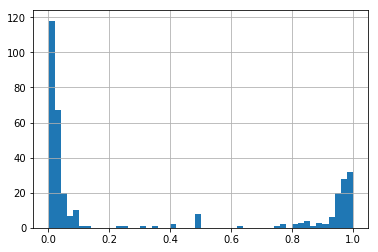

In [31]:
# Check out predicted probabilities: Distribution should be balanced
prob_col = 'prediction_relt_prob_yes'
relt_df[prob_col].hist(bins=50)

## Evaluate algorithms: Demographic perspective

In [32]:
######################################################
# Prepare training and validation data
######################################################

# Separate training and final validation data set. First reltove class
# label from data (X). Setup target class (Y)
# Then make the validation set 10% of the entire
# set of labeled data (X_validate, Y_validate)

demog_df = demog_df[['text', 'demographic_score']]
print("Number of cases:", str(X_demog.shape[0]))

valueArray = demog_df.values
Y = valueArray[:,1]
Y = Y.astype('float')
print("Number of codes (should match):", str(len(Y)))

Number of cases: 733
Number of codes (should match): 733


In [33]:
######################################################
# Oversample to desirable ratio
######################################################

X_balanced, Y_balanced = resample_data(
    X_demog, Y, 
    undersample=undersample, 
    sampling_ratio=sampling_ratio)

Y_train: Counter({0.0: 477, 1.0: 256})
Y_resample: Counter({1.0: 477, 0.0: 477})


In [34]:
######################################################
# Use different algorithms to build models
######################################################

models = []
models.append(('K-Nearest Neighbors (KNN)', KNeighborsClassifier()))
models.append(('Random Forest (RF)', RandomForestClassifier(random_state=seed)))
models.append(('Decision Tree (DT)', DecisionTreeClassifier(random_state=seed)))
models.append(('Multinomial Naive Bayes (MNB)', MultinomialNB()))
models.append(('Logistic Regression (LR)', LogisticRegression(random_state=seed)))
models.append(('Support Vector Machine (SVM)', SVC(gamma='auto')))
models.append(('Multi-Layer Perceptron (MLP)', mlp))
#models.append(('Ensemble model (MLP + Logit)', ensemble))

# Baseline: distribution of labeled data
print(f'Distribution of labeled demographic articles: {Counter(Y).most_common()}')
print()

# Evaluate algorithms using 10-fold cross validation
results, names = show_kfold_output(models=models, 
                                   X=X_balanced,
                                   Y=Y_balanced, 
                                   df=demog_df, 
                                   text_col='text', 
                                   vectorizer=demog_vectorizer)

Distribution of labeled demographic articles: [(0.0, 477), (1.0, 256)]

K-Nearest Neighbors (KNN):



Computing predictions:   0%|          | 1/733 [00:00<00:02, 277.00it/s]


Mean (std):	 0.5786 (0.4938)
Accuracy:	 {1, 4}

Confusion matrix:
 [[251 226]
 [151 326]]

Report:
               precision    recall  f1-score   support

         0.0       0.62      0.53      0.57       477
         1.0       0.59      0.68      0.63       477

    accuracy                           0.60       954
   macro avg       0.61      0.60      0.60       954
weighted avg       0.61      0.60      0.60       954


Random Forest (RF):



Computing predictions:   0%|          | 1/733 [00:00<00:00, 972.48it/s]


Mean (std):	 0.3983 (0.4896)
Accuracy:	 {1, 4}

Confusion matrix:
 [[446  31]
 [128 349]]

Report:
               precision    recall  f1-score   support

         0.0       0.78      0.94      0.85       477
         1.0       0.92      0.73      0.81       477

    accuracy                           0.83       954
   macro avg       0.85      0.83      0.83       954
weighted avg       0.85      0.83      0.83       954


Decision Tree (DT):



Computing predictions:   0%|          | 1/733 [00:00<00:02, 318.72it/s]


Mean (std):	 0.6216 (0.485)
Accuracy:	 {1, 4}

Confusion matrix:
 [[276 201]
 [ 85 392]]

Report:
               precision    recall  f1-score   support

         0.0       0.76      0.58      0.66       477
         1.0       0.66      0.82      0.73       477

    accuracy                           0.70       954
   macro avg       0.71      0.70      0.70       954
weighted avg       0.71      0.70      0.70       954


Multinomial Naive Bayes (MNB):



Computing predictions:   0%|          | 1/733 [00:00<00:00, 1074.36it/s]


Mean (std):	 0.6688 (0.4707)
Accuracy:	 {1, 4}

Confusion matrix:
 [[216 261]
 [100 377]]

Report:
               precision    recall  f1-score   support

         0.0       0.68      0.45      0.54       477
         1.0       0.59      0.79      0.68       477

    accuracy                           0.62       954
   macro avg       0.64      0.62      0.61       954
weighted avg       0.64      0.62      0.61       954


Logistic Regression (LR):



Computing predictions:   0%|          | 1/733 [00:00<00:01, 495.43it/s]


Mean (std):	 0.5021 (0.5)
Accuracy:	 {1, 4}

Confusion matrix:
 [[348 129]
 [127 350]]

Report:
               precision    recall  f1-score   support

         0.0       0.73      0.73      0.73       477
         1.0       0.73      0.73      0.73       477

    accuracy                           0.73       954
   macro avg       0.73      0.73      0.73       954
weighted avg       0.73      0.73      0.73       954


Support Vector Machine (SVM):



Computing predictions:   0%|          | 1/733 [00:00<00:01, 439.06it/s]


Mean (std):	 0.5996 (0.49)
Accuracy:	 {0, 4}

Confusion matrix:
 [[174 303]
 [208 269]]

Report:
               precision    recall  f1-score   support

         0.0       0.46      0.36      0.41       477
         1.0       0.47      0.56      0.51       477

    accuracy                           0.46       954
   macro avg       0.46      0.46      0.46       954
weighted avg       0.46      0.46      0.46       954


Multi-Layer Perceptron (MLP):



Computing predictions:   0%|          | 1/733 [00:00<00:08, 87.49it/s]

Mean (std):	 0.4864 (0.4998)
Accuracy:	 {1, 4}

Confusion matrix:
 [[390  87]
 [100 377]]

Report:
               precision    recall  f1-score   support

         0.0       0.80      0.82      0.81       477
         1.0       0.81      0.79      0.80       477

    accuracy                           0.80       954
   macro avg       0.80      0.80      0.80       954
weighted avg       0.80      0.80      0.80       954




In [35]:
######################################################
# Save best model
######################################################

best_model_suffix = "" # selected model
demog_model_fp = model_fp + f'classifier_demog_{str(best_model_suffix)}_{str(thisday)}.joblib'

# demog_model = MLPClassifier(max_iter=100, activation='relu').fit(X_balanced, Y_balanced) 
             # DecisionTreeClassifier(random_state=seed).fit(X_balanced, Y_balanced) 
             # RandomForestClassifier(random_state=seed).fit(X_balanced, Y_balanced)
        
#joblib.dump(demog_model, demog_model_fp)

### Validation step: Use selected model to predict class probabilities in training data

In [36]:
# Make predictions
#demog_model = MLPClassifier(max_iter=100, activation='relu').fit(X_demog, Y)
tqdm.pandas(desc = "Predicting: demographic persp.")
demog_df[['prediction_demog','prediction_demog_prob_yes','prediction_demog_prob_no']] = demog_df['text'].progress_apply(lambda sentlist: pd.Series(compute_predictions([' '.join(sent) for sent in sentlist], demog_vectorizer, demog_model)))

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
Predicting: demographic persp.: 100%|██████████| 349/349 [00:04<00:00, 84.86it/s] 


In [37]:
# Check out predictions: labels should be balanced
pred_col = 'prediction_demog'
demog_df[pred_col].value_counts()

no     246
yes    103
Name: prediction_demog, dtype: int64

In [38]:
# Compare to distribution of labeled data
print(f'Distribution of labeled demographic data: {Counter(Y).most_common()}')

Distribution of labeled demographic data: [(0.0, 248), (1.0, 101)]


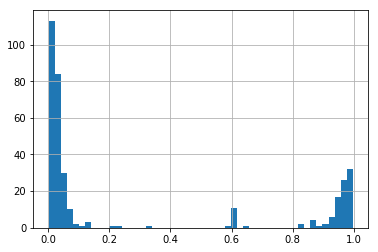

In [39]:
# Check out predicted probabilities: Distribution should be balanced
prob_col = 'prediction_demog_prob_yes'
demog_df[prob_col].hist(bins=50)

## Evaluate algorithms: Organizational Sociology perspective

In [36]:
######################################################
# Prepare training and validation data
######################################################

# Separate training and final validation data set. First reltove class
# label from data (X). Setup target class (Y)
# Then make the validation set 10% of the entire
# set of labeled data (X_validate, Y_validate)

orgs_df = orgs_df[['text', 'orgs_score']]
print("Number of cases:", str(X_orgs.shape[0]))

valueArray = orgs_df.values
Y = valueArray[:,1]
Y = Y.astype('float')
print("Number of codes (should match):", str(len(Y)))

Number of cases: 814
Number of codes (should match): 814


In [37]:
######################################################
# Oversample to desirable ratio
######################################################

X_balanced, Y_balanced = resample_data(
    X_orgs, Y, 
    undersample=undersample, 
    sampling_ratio=sampling_ratio)

Y_train: Counter({1.0: 511, 0.0: 303})
Y_resample: Counter({1.0: 511, 0.0: 511})


In [ ]:
######################################################
# Use different algorithms to build models
######################################################

models = []
models.append(('K-Nearest Neighbors (KNN)', KNeighborsClassifier()))
models.append(('Random Forest (RF)', RandomForestClassifier(random_state=seed)))
models.append(('Decision Tree (DT)', DecisionTreeClassifier(random_state=seed)))
models.append(('Multinomial Naive Bayes (MNB)', MultinomialNB()))
models.append(('Logistic Regression (LR)', LogisticRegression(random_state=seed)))
models.append(('Support Vector Machine (SVM)', SVC(gamma='auto')))
models.append(('Multi-Layer Perceptron (MLP)', mlp))
#models.append(('Ensemble model (MLP + Logit)', ensemble))

# Baseline: distribution of labeled data
print(f'Distribution of labeled orgs articles: {Counter(Y).most_common()}')
print()

# Evaluate algorithms using 10-fold cross validation
results, names = show_kfold_output(models=models, 
                                   X=X_balanced,
                                   Y=Y_balanced, 
                                   df=orgs_df, 
                                   text_col='text', 
                                   vectorizer=orgs_vectorizer)

Distribution of labeled orgs articles: [(1.0, 511), (0.0, 303)]

K-Nearest Neighbors (KNN):



Computing predictions:   0%|          | 1/814 [00:00<00:00, 1142.24it/s]


Mean (std):	 0.4843 (0.4998)
Accuracy:	 {1, 4}

Confusion matrix:
 [[340 171]
 [187 324]]

Report:
               precision    recall  f1-score   support

         0.0       0.65      0.67      0.66       511
         1.0       0.65      0.63      0.64       511

    accuracy                           0.65      1022
   macro avg       0.65      0.65      0.65      1022
weighted avg       0.65      0.65      0.65      1022


Random Forest (RF):



In [35]:
######################################################
# Save best model
######################################################

best_model_suffix = "" # selected model
orgs_model_fp = model_fp + f'classifier_orgs_{str(best_model_suffix)}_{str(thisday)}.joblib'

# orgs_model = MLPClassifier(max_iter=100, activation='relu').fit(X_balanced, Y_balanced) 
             # DecisionTreeClassifier(random_state=seed).fit(X_balanced, Y_balanced) 
             # RandomForestClassifier(random_state=seed).fit(X_balanced, Y_balanced)
        
#joblib.dump(orgs_model, orgs_model_fp)

### Validation step: Use selected model to predict class probabilities in training data

In [36]:
# Make predictions
#orgs_model = MLPClassifier(max_iter=100, activation='relu').fit(X_orgs, Y) # RandomForestClassifier(random_state=seed).fit(X_demog, Y)
tqdm.pandas(desc = "Predicting: orgs persp.")
orgs_df[['prediction_orgs','prediction_orgs_prob_yes','prediction_orgs_prob_no']] = orgs_df['text'].progress_apply(lambda sentlist: pd.Series(compute_predictions([' '.join(sent) for sent in sentlist], orgs_vectorizer, orgs_model)))

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
Predicting: demographic persp.: 100%|██████████| 349/349 [00:04<00:00, 84.86it/s] 


In [37]:
# Check out predictions: labels should be balanced
pred_col = 'prediction_orgs'
orgs_df[pred_col].value_counts()

no     246
yes    103
Name: prediction_demog, dtype: int64

In [38]:
# Compare to distribution of labeled data
print(f'Distribution of labeled orgs data: {Counter(Y).most_common()}')

Distribution of labeled demographic data: [(0.0, 248), (1.0, 101)]


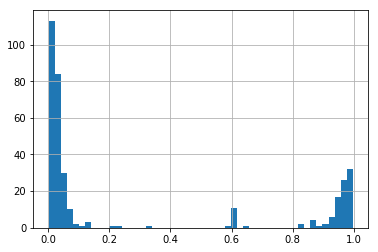

In [39]:
# Check out predicted probabilities: Distribution should be balanced
prob_col = 'prediction_orgs_prob_yes'
orgs_df[prob_col].hist(bins=50)

# Comparison plots for accuracies

In [5]:
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt

In [6]:
perspective = ['Culture', 'Culture', 'Culture', 'Culture', 'Culture', 'Culture', 'Culture', 'Culture',
              'Demographic', 'Demographic', 'Demographic', 'Demographic', 'Demographic','Demographic', 'Demographic', 'Demographic',
              'Relational', 'Relational', 'Relational', 'Relational', 'Relational', 'Relational', 'Relational', 'Relational']
score = [0.83, 0.91, 0.85, 0.79, 0.88, 0.92, 0.46, 0.40,
         0.88, 0.97, 0.91, 0.88, 0.98, 0.98, 0.44, 0.32,
         0.84, 0.97, 0.91, 0.84, 0.94, 0.96, 0.49, 0.34]
md = ['K-Nearest Neighbors', 'Random Forest', 'Decision Tree', 'Multinomial Naive Bayes', 'Logistic Regression', 
      'Multilayer Perceptron', 'Support Vector Machine', 'Convolutional Neural Network',
      'K-Nearest Neighbors', 'Random Forest', 'Decision Tree', 'Multinomial Naive Bayes', 'Logistic Regression', 
      'Multilayer Perceptron', 'Support Vector Machine', 'Convolutional Neural Network', 
      'K-Nearest Neighbors', 'Random Forest', 'Decision Tree', 'Multinomial Naive Bayes', 'Logistic Regression', 
      'Multilayer Perceptron', 'Support Vector Machine', 'Convolutional Neural Network']

In [7]:
df_plot = pd.DataFrame({'perspective': perspective, 'score': score, 'model':md})

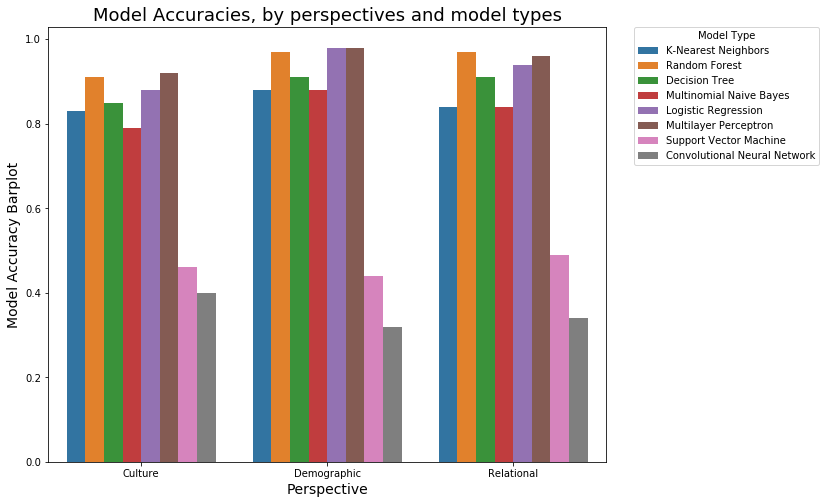

In [8]:
plt.figure(figsize=(10, 8))
sns.barplot(x="perspective", 
            y="score", 
            hue="model", 
            data=df_plot)
plt.ylabel("Model Accuracy Barplot", size=14)
plt.xlabel("Perspective", size=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title = 'Model Type')
plt.title("Model Accuracies, by perspectives and model types", size=18)
plt.savefig("model_accuracy_barplot.png", bbox_inches='tight')
plt.show()